In [72]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.nn import softmax
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.losses import categorical_crossentropy
from sklearn.utils import shuffle

In [ ]:
# Shuffle the dataset as soon as you read the file
# make the train and test split in the data before training
# during training use the validation set to check accuracy
# print the test data accuracy and loss
# Draw loss / accuracy / confusion matrix graph

In [61]:
df = pd.read_csv("./weather.csv")
df = shuffle(df)

# deleting bad data
df.drop(["Daily Summary","Formatted Date","Loud Cover","Apparent Temperature (C)"], axis=1, inplace = True)
df.dropna(axis=0,inplace=True)

df["Summary"].value_counts()

Partly Cloudy                          31635
Mostly Cloudy                          27914
Overcast                               16516
Clear                                  10763
Foggy                                   7117
Breezy and Overcast                      528
Breezy and Mostly Cloudy                 516
Breezy and Partly Cloudy                 386
Dry and Partly Cloudy                     86
Windy and Partly Cloudy                   67
Light Rain                                63
Breezy                                    54
Windy and Overcast                        45
Humid and Mostly Cloudy                   40
Drizzle                                   39
Breezy and Foggy                          35
Windy and Mostly Cloudy                   35
Dry                                       34
Humid and Partly Cloudy                   17
Dry and Mostly Cloudy                     14
Rain                                      10
Windy                                      8
Humid and 

In [62]:

# making label's frequecy same, to avoid bias
for summary,s_df in df.groupby("Summary"):
    if len(s_df)< 5000:
        df.drop(s_df.index,axis=0,inplace=True)

    elif len(s_df) > 7000:
        x = len(s_df) - 7000
        df.drop(s_df[:x].index,axis=0,inplace=True)
        
df.reset_index(inplace=True)

# converting categorical data into numeric
df[["rain","snow"]] = pd.get_dummies(df["Precip Type"])
df.drop(["Precip Type","index"], axis = 1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Summary                 35000 non-null  object 
 1   Temperature (C)         35000 non-null  float64
 2   Humidity                35000 non-null  float64
 3   Wind Speed (km/h)       35000 non-null  float64
 4   Wind Bearing (degrees)  35000 non-null  int64  
 5   Visibility (km)         35000 non-null  float64
 6   Pressure (millibars)    35000 non-null  float64
 7   rain                    35000 non-null  uint8  
 8   snow                    35000 non-null  uint8  
dtypes: float64(5), int64(1), object(1), uint8(2)
memory usage: 1.9+ MB


In [63]:
# normalization
x = df[["Humidity","Pressure (millibars)", "Temperature (C)","Visibility (km)","Wind Bearing (degrees)","Wind Speed (km/h)"]]
org_mean, org_std = x.mean(), x.std()

df[["Humidity","Pressure (millibars)", "Temperature (C)","Visibility (km)","Wind Bearing (degrees)","Wind Speed (km/h)"]] = (x - org_mean)/ org_std


targets = df[["Summary"]]
inputs = df.drop(["Summary"], axis= 1)
inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (C)         35000 non-null  float64
 1   Humidity                35000 non-null  float64
 2   Wind Speed (km/h)       35000 non-null  float64
 3   Wind Bearing (degrees)  35000 non-null  float64
 4   Visibility (km)         35000 non-null  float64
 5   Pressure (millibars)    35000 non-null  float64
 6   rain                    35000 non-null  uint8  
 7   snow                    35000 non-null  uint8  
dtypes: float64(6), uint8(2)
memory usage: 1.7 MB


In [64]:
# one hot encoding the targets 
one_hot_targets = pd.get_dummies(targets)

labels = targets["Summary"].unique()
labels.sort()
labels

array(['Clear', 'Foggy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy'],
      dtype=object)

In [65]:
train_inputs = inputs[:30000]
train_targets = one_hot_targets[:30000]

test_inputs  = inputs[30000:]
test_targets = one_hot_targets[30000:]

In [66]:
# converting into tensors
inputs_tf = tf.constant(train_inputs)
targets_tf = tf.cast(tf.constant(train_targets), tf.float64)

In [67]:
model = Sequential([
    layers.Dense(5),
    layers.Softmax()
])

# model.build(input_shape=inputs_tf.shape)

In [68]:
model.compile(
    loss = categorical_crossentropy,
    optimizer = SGD(learning_rate=0.001),
    metrics = ["accuracy"]
)

In [69]:
history = model.fit(
    inputs_tf,
    targets_tf,
    epochs = 100,
    batch_size = 100,
    validation_split = 0.3
)

Epoch 1/100
210/210 [==============================] - 0s 931us/step - loss: 1.6105 - accuracy: 0.2887 - val_loss: 1.7221 - val_accuracy: 0.2678
Epoch 2/100
210/210 [==============================] - 0s 688us/step - loss: 1.5428 - accuracy: 0.3458 - val_loss: 1.7001 - val_accuracy: 0.2810
Epoch 3/100
210/210 [==============================] - 0s 680us/step - loss: 1.4864 - accuracy: 0.3869 - val_loss: 1.6820 - val_accuracy: 0.2898
Epoch 4/100
210/210 [==============================] - 0s 647us/step - loss: 1.4392 - accuracy: 0.4150 - val_loss: 1.6672 - val_accuracy: 0.2909
Epoch 5/100
210/210 [==============================] - 0s 672us/step - loss: 1.3997 - accuracy: 0.4363 - val_loss: 1.6548 - val_accuracy: 0.2941
Epoch 6/100
210/210 [==============================] - 0s 694us/step - loss: 1.3662 - accuracy: 0.4497 - val_loss: 1.6444 - val_accuracy: 0.2953
Epoch 7/100
210/210 [==============================] - 0s 694us/step - loss: 1.3376 - accuracy: 0.4596 - val_loss: 1.6354 - val_ac

In [70]:
# model.save("./weather_summary")
model.save("./weather_summary.h5", save_format="h5")

In [71]:
loss, accuracy = model.test_on_batch(test_inputs, test_targets)
print(accuracy)

0.30300000309944153


In [125]:
preds = model.predict(inputs_tf)
preds_simplified = []
targets_simplified = []

for pred in preds:
    index = (tf.where(pred == max(pred)))
    index = (int(index[0][0]))
    preds_simplified.append(index)
    
for target in targets_tf:
    index = (tf.where(target == max(target)))
    index = (int(index[0][0]))
    targets_simplified.append(index)

<Axes: >

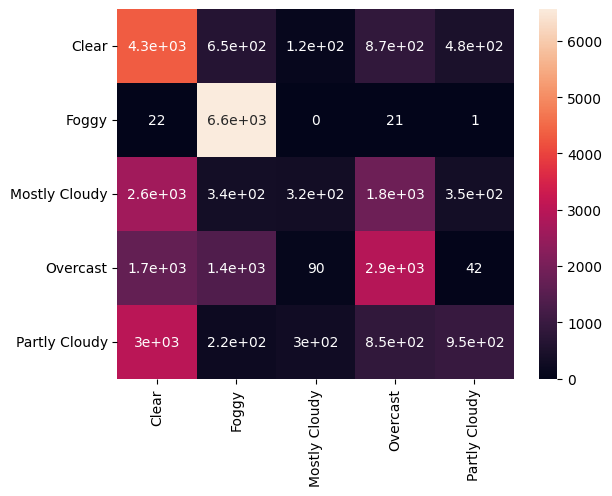

In [126]:
import seaborn as sns

confusion = tf.math.confusion_matrix(labels=targets_simplified, predictions= preds_simplified)
conf_df = pd.DataFrame(confusion, labels, labels)
sns.heatmap(conf_df, annot=True)

In [9]:
# model = tf.keras.models.load_model("./weather_summary")
model = tf.keras.models.load_model('./weather_summary.h5')

In [127]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,1.610462,0.288667,1.722117,0.267778
1,1.542832,0.345810,1.700071,0.281000
2,1.486376,0.386857,1.682046,0.289778
3,1.439231,0.415000,1.667193,0.290889
4,1.399675,0.436286,1.654828,0.294111
...,...,...,...,...
95,1.008236,0.580905,1.436594,0.316333
96,1.007631,0.581048,1.435948,0.316889
97,1.007034,0.581143,1.435320,0.317333
98,1.006448,0.581714,1.434693,0.317333


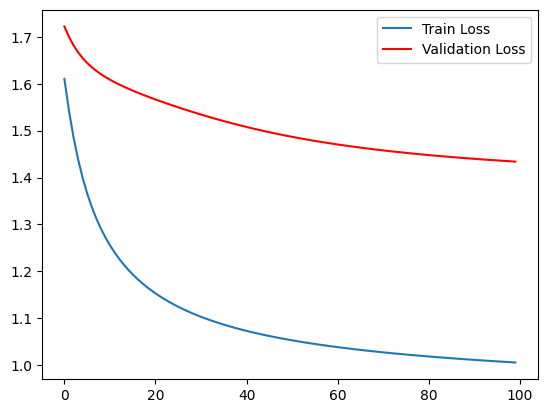

In [133]:
plt.plot(range(100),history_df["loss"])
plt.plot(range(100),history_df["val_loss"], c="red")
plt.legend(["Train Loss", "Validation Loss"])

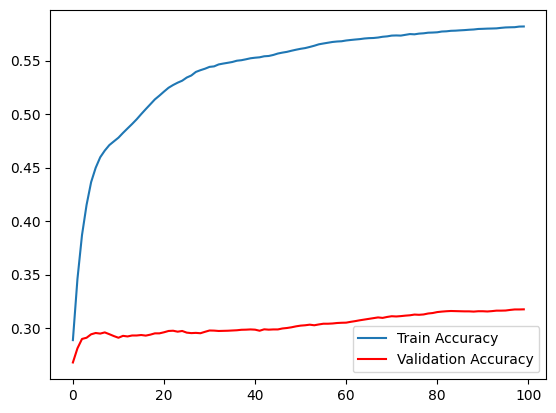

In [134]:
plt.plot(range(100),history_df["accuracy"])
plt.plot(range(100),history_df["val_accuracy"], c="red")
plt.legend(["Train Accuracy", "Validation Accuracy"])